
### Hybrid Quantum Neural Network (HQNN) for Material Classification

This notebook trains a hybrid quantum-classical neural network to classify 
CaF2 and CaF2:Er materials based on optical properties. It uses a 
ZZ feature map with an EfficientSU2 ansatz for the quantum layer.



In [1]:
# =============================================================================
#  Imports and Setup
# =============================================================================

import sys
import time
import copy
import os
import json
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.auto import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve, auc, classification_report
)
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

from qiskit.circuit.library import zz_feature_map, efficient_su2
from qiskit.quantum_info import SparsePauliOp
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

In [2]:
# =============================================================================
#  Configuration
# =============================================================================

CONFIG = {
    "BACKEND_MODE": "NOISY",
    "IBM_CHANNEL": "ibm_quantum",
    "IBM_TOKEN": None,
    "REAL_BACKEND_NAME": "ibm_brisbane",
    "RANDOM_SEED": 42,
    "TEST_SIZE": 0.2,
    "VAL_SIZE": 0.2,
    "BATCH_SIZE": 32,
    "EPOCHS": 2,
    "LR_QUANTUM": 0.01,
    "LR_CLASSICAL": 0.01,
    "SVM_C": 1.0,
    "MAX_SAMPLES": 200,
    "TRAINABLE_INPUTS": True,
    "DATA_DIR": Path("/teamspace/studios/this_studio/Q-UCSpec/data/"),
    "CAF2_FILE": "caf2_qml_full_descriptors.csv",
    "CAF2_ER_FILE": "caf2_er_qml_full_descriptors.csv",
    "FM_REPS": 1,
    "SPLIT_SEED": 42,
    "MAX_QNN_SAMPLES": 200,
    "LEARNING_RATE": 0.01,
    "ES_PATIENCE": 15,
    "ES_MIN_DELTA": 0.0005,
    "ANSATZ_REPS": 4,
    "RESULTS_DIR": "./QAMP_results/",
    "MAX_TRAIN_SAMPLES": 1000,
}

SPLIT_SEED = CONFIG["SPLIT_SEED"]
NUM_QUBITS = 3
FEATURES = []
RESULTS = {}



In [3]:
# =============================================================================
#  Data Loading Functions
# =============================================================================

def select_features_and_load(data_dir):
    """
    Loads CaF2 and CaF2:Er datasets, applies feature selection using 
    linear SVM coefficients, and returns train/val/test splits as tensors.
    """
    global FEATURES
    
    try:
        caf2 = pd.read_csv(data_dir / CONFIG["CAF2_FILE"])
        er = pd.read_csv(data_dir / CONFIG["CAF2_ER_FILE"])
    except Exception as e:
        print(f"Error loading files: {e}")
        return generate_synthetic_data()

    caf2['label'] = 0
    er['label'] = 1
    df = pd.concat([caf2, er], ignore_index=True)
    
    target_features = ["κ (Extinction coeff)", "α (Absorption cm^-1)", "Energy (eV)"]
    
    missing = [f for f in target_features if f not in df.columns]
    if missing:
        raise ValueError(f"Required features not found: {missing}")
        
    X_full = df[target_features].values
    y = df["label"].values

    X_train_full, X_temp_full, y_train, y_temp = train_test_split(
        X_full, y, test_size=0.20, stratify=y, random_state=SPLIT_SEED
    )
    X_val_full, X_test_full, y_val, y_test = train_test_split(
        X_temp_full, y_temp, test_size=0.50, stratify=y_temp, random_state=SPLIT_SEED
    )

    scaler = PowerTransformer(method='box-cox', standardize=True)
    X_train_s = scaler.fit_transform(X_train_full)
    X_val_s = scaler.transform(X_val_full)
    X_test_s = scaler.transform(X_test_full)

    svm_linear = SVC(kernel="linear")
    svm_linear.fit(X_train_s, y_train)

    coefs = np.abs(svm_linear.coef_[0])
    top3_idx = np.argsort(coefs)[-3:][::-1]
    top3_features = [target_features[i] for i in top3_idx]
    FEATURES = top3_features

    print("\n===== TOP-3 FEATURES SELECTED =====")
    for f in top3_features:
        print(f" • {f}")
    print("====================================\n")

    X_train = X_train_s[:, top3_idx]
    X_val = X_val_s[:, top3_idx]
    X_test = X_test_s[:, top3_idx]

    max_train = CONFIG.get("MAX_TRAIN_SAMPLES")
    if max_train is not None and len(X_train) > max_train:
        subset_ratio = max_train / len(X_train)
        X_train, _, y_train, _ = train_test_split(
            X_train, y_train, 
            train_size=subset_ratio, 
            stratify=y_train, 
            random_state=SPLIT_SEED
        )
        print(f"Subsampled training data to {len(X_train)} samples")

    print(f"Splits: Train={len(X_train)} | Val={len(X_val)} | Test={len(X_test)}")
    
    return (
        torch.tensor(X_train, dtype=torch.float64),
        torch.tensor(X_val, dtype=torch.float64),
        torch.tensor(X_test, dtype=torch.float64),
        torch.tensor(y_train, dtype=torch.float64).reshape(-1, 1),
        torch.tensor(y_val, dtype=torch.float64).reshape(-1, 1),
        torch.tensor(y_test, dtype=torch.float64).reshape(-1, 1)
    )


def generate_synthetic_data():
    """Generates synthetic classification data as fallback."""
    from sklearn.datasets import make_classification
    
    X, y = make_classification(n_samples=500, n_features=6, n_informative=3, random_state=42)
    X = X[:, :3]
    scaler = MinMaxScaler(feature_range=(-np.pi/2, np.pi/2))
    X = scaler.fit_transform(X)
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    return (
        torch.tensor(X_train, dtype=torch.float64),
        torch.tensor(X_val, dtype=torch.float64),
        torch.tensor(X_test, dtype=torch.float64),
        torch.tensor(y_train, dtype=torch.float64).reshape(-1, 1),
        torch.tensor(y_val, dtype=torch.float64).reshape(-1, 1),
        torch.tensor(y_test, dtype=torch.float64).reshape(-1, 1)
    )


def check_label_distribution(y, dataset_name="Train"):
    """Prints class distribution statistics for a given dataset."""
    unique, counts = np.unique(y, return_counts=True)
    total_samples = len(y)

    print(f"\n--- {dataset_name} Set Label Distribution ---")
    print(f"Total Samples: {total_samples}")

    for label, count in zip(unique, counts):
        percentage = (count / total_samples) * 100
        print(f" Class {label}: {count} samples ({percentage:.2f}%)")

    if len(counts) > 1:
        imbalance_ratio = max(counts) / min(counts)
        print(f" Imbalance Ratio: 1 : {imbalance_ratio:.2f}")
        if imbalance_ratio > 1.5:
            print(" Warning: Class imbalance detected.")
    print("-" * 40)



In [4]:
# =============================================================================
#  Visualization Functions
# =============================================================================

def plot_selected_features(data_dir):
    """Creates a pairplot of the selected features colored by class."""
    try:
        caf2 = pd.read_csv(data_dir / CONFIG["CAF2_FILE"])
        er = pd.read_csv(data_dir / CONFIG["CAF2_ER_FILE"])
    except Exception as e:
        print(f"Error loading files: {e}")
        return

    caf2['label'] = 0
    er['label'] = 1
    df = pd.concat([caf2, er], ignore_index=True)
    
    target_features = ["κ (Extinction coeff)", "α (Absorption cm^-1)", "Energy (eV)"]
    
    missing = [f for f in target_features if f not in df.columns]
    if missing:
        raise ValueError(f"Required features not found: {missing}")

    plot_df = df[target_features + ['label']].copy()
    plot_df['label'] = plot_df['label'].map({0: 'CaF2', 1: 'CaF2:Er'})

    sns.set(style='whitegrid')
    pp = sns.pairplot(plot_df, hue='label', palette='tab10', diag_kind='kde')
    pp.fig.suptitle("Pairplot of Selected Features", y=1.02)
    plt.show()


def plot_class_distribution(y_train):
    """Plots bar chart of training set class distribution."""
    labels = ['CaF₂', 'CaF₂:Er']
    count_neg = int((y_train == 0).sum().item())
    count_pos = int((y_train == 1).sum().item())
    counts = [count_neg, count_pos]

    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar(labels, counts, color=['#3498db', '#e74c3c'])
    ax.set_ylabel('Count')
    ax.set_title('Training Set Class Distribution')

    for bar, count in zip(bars, counts):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 5, str(count), ha='center')

    plt.tight_layout()
    plt.show()

    imbalance = counts[0] / counts[1] if counts[1] != 0 else float('inf')
    print(f"Class imbalance ratio: {imbalance:.3f}")


In [5]:
# =============================================================================
#  Analysis Functions
# =============================================================================

def check_fit_status(model_name, train_acc, val_acc):
    """Analyzes training vs validation accuracy for overfitting/underfitting."""
    print(f"\n===== FIT ANALYSIS → {model_name} =====")

    gap = train_acc - val_acc
    print(f"Train Acc: {train_acc:.3f}")
    print(f"Val Acc:   {val_acc:.3f}")
    print(f"Gap:       {gap:.3f}")

    if train_acc > 0.90 and gap > 0.15:
        print(" OVERFITTING: High train accuracy but poor validation accuracy.")
    elif gap > 0.10:
        print(" Mild Overfitting detected.")
    elif train_acc < 0.60 and val_acc < 0.60:
        print(" UNDERFITTING: Model cannot learn meaningful patterns.")
    else:
        print(" GOOD FIT: No signs of over/underfitting.")


def classical_baseline(X_train, y_train, X_val, y_val, X_test, y_test):
    """Trains and evaluates a classical SVM as baseline comparison."""
    print("\n===== Classical Support Vector Machine (SVM) =====")

    svm = SVC(kernel="rbf")
    svm.fit(X_train, y_train)

    pred_train = svm.predict(X_train)
    pred_val = svm.predict(X_val)
    pred_test = svm.predict(X_test)

    acc_train = accuracy_score(y_train, pred_train)
    acc_val = accuracy_score(y_val, pred_val)
    acc_test = accuracy_score(y_test, pred_test)

    print(f"Train: {acc_train:.4f}")
    print(f"Val:   {acc_val:.4f}")
    print(f"Test:  {acc_test:.4f}")

    y_test_score = svm.decision_function(X_test)
    feature_importance_score = permutation_importance(
        svm, X_test, y_test, scoring='accuracy', n_repeats=10, random_state=0
    ).importances_mean

    check_fit_status("Classical SVM", acc_train, acc_val)

    RESULTS["Classical SVM"] = {
        "acc_train": acc_train,
        "acc_val": acc_val,
        "acc_test": acc_test,
        "y_test_score": y_test_score.tolist(),
        "feature_score": feature_importance_score.tolist()
    }

    return svm

In [6]:
# =============================================================================
#  Model Definition
# =============================================================================

def scale_to_phase(x: torch.Tensor) -> torch.Tensor:
    """Maps input values to [0, pi] range using sigmoid activation."""
    return torch.sigmoid(x) * np.pi


class NeuralModel(nn.Module):
    """
    Hybrid Quantum Neural Network model combining a quantum circuit layer 
    with a classical fully-connected output layer.
    """
    
    def __init__(self, qnn, n_classes=2):
        super().__init__()
        self.qnn = TorchConnector(
            qnn, 
            initial_weights=np.random.uniform(-0.01, 0.01, qnn.num_weights)
        )
        self.fc = nn.Linear(NUM_QUBITS, n_classes)

    def forward(self, x):
        x_scaled = scale_to_phase(x)
        expvals = self.qnn(x_scaled)
        logits = self.fc(expvals)
        return logits


class EarlyStopping:
    """Stops training when validation loss stops improving."""
    
    def __init__(self, patience=10, min_delta=0.0, min_epochs=0):
        self.patience = patience
        self.min_delta = min_delta
        self.min_epochs = min_epochs
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, epoch):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.counter = 0
            return

        if val_loss > self.best_loss - self.min_delta or epoch < self.min_epochs:
            self.counter += 1
            if self.counter >= self.patience and epoch >= self.min_epochs:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [7]:

# =============================================================================
#  Load Data
# =============================================================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

X_train, X_val, X_test, y_train, y_val, y_test = select_features_and_load(CONFIG["DATA_DIR"])


Using device: cpu

===== TOP-3 FEATURES SELECTED =====
 • α (Absorption cm^-1)
 • κ (Extinction coeff)
 • Energy (eV)

Subsampled training data to 1000 samples
Splits: Train=1000 | Val=288 | Test=289


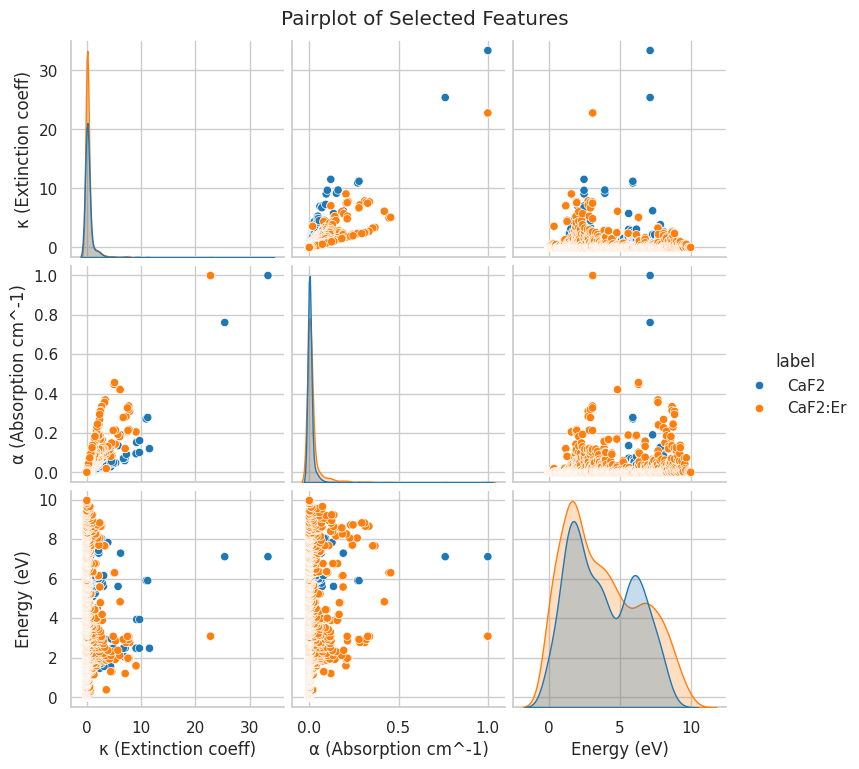

In [8]:
# =============================================================================
#  Visualize Features (Pairplot)
# =============================================================================

plot_selected_features(CONFIG["DATA_DIR"])



--- Training Set Label Distribution ---
Total Samples: 1000
 Class 0.0: 448 samples (44.80%)
 Class 1.0: 552 samples (55.20%)
 Imbalance Ratio: 1 : 1.23
----------------------------------------

--- Test Set Label Distribution ---
Total Samples: 289
 Class 0.0: 130 samples (44.98%)
 Class 1.0: 159 samples (55.02%)
 Imbalance Ratio: 1 : 1.22
----------------------------------------

--- Validation Set Label Distribution ---
Total Samples: 288
 Class 0.0: 129 samples (44.79%)
 Class 1.0: 159 samples (55.21%)
 Imbalance Ratio: 1 : 1.23
----------------------------------------


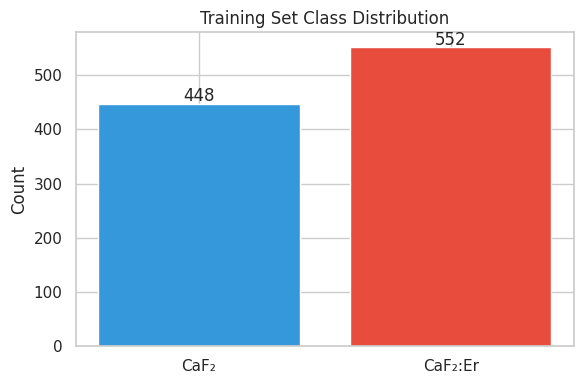

Class imbalance ratio: 0.812


In [9]:
# =============================================================================
#  Check Label Distribution
# =============================================================================

check_label_distribution(y_train, "Training")
check_label_distribution(y_test, "Test")
check_label_distribution(y_val, "Validation")

plot_class_distribution(y_train)

In [10]:

# =============================================================================
#  Classical SVM Baseline
# =============================================================================

classical_baseline(
    X_train.numpy(), y_train.numpy().ravel(),
    X_val.numpy(), y_val.numpy().ravel(),
    X_test.numpy(), y_test.numpy().ravel()
)


===== Classical Support Vector Machine (SVM) =====
Train: 0.9830
Val:   0.9792
Test:  0.9689

===== FIT ANALYSIS → Classical SVM =====
Train Acc: 0.983
Val Acc:   0.979
Gap:       0.004
 GOOD FIT: No signs of over/underfitting.


,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'rbf'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",False
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",None
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [11]:

# =============================================================================
#  Create DataLoaders
# =============================================================================

train_dataset = TensorDataset(
    X_train.clone().detach().to(dtype=torch.float32),
    y_train.clone().detach().to(dtype=torch.long).squeeze(),
)
val_dataset = TensorDataset(
    X_val.clone().detach().to(dtype=torch.float32),
    y_val.clone().detach().to(dtype=torch.long).squeeze(),
)
test_dataset = TensorDataset(
    X_test.clone().detach().to(dtype=torch.float32),
    y_test.clone().detach().to(dtype=torch.long).squeeze(),
)

train_loader = DataLoader(train_dataset, batch_size=CONFIG["BATCH_SIZE"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG["BATCH_SIZE"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG["BATCH_SIZE"], shuffle=False)




In [12]:

# =============================================================================
#  Build Quantum Circuit and QNN
# =============================================================================

feature_map = zz_feature_map(feature_dimension=NUM_QUBITS, reps=CONFIG["FM_REPS"])
ansatz = efficient_su2(num_qubits=NUM_QUBITS, reps=CONFIG["ANSATZ_REPS"], entanglement='circular')
qc = feature_map.compose(ansatz)

observables = [
    SparsePauliOp('I'*i + 'Z' + 'I'*(NUM_QUBITS-1-i)) 
    for i in range(NUM_QUBITS)
]

qnn = EstimatorQNN(
    circuit=qc, 
    observables=observables,
    input_params=feature_map.parameters, 
    weight_params=ansatz.parameters
)


No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


In [13]:
# =============================================================================
#  Initialize Model and Training Components
# =============================================================================

model = NeuralModel(qnn).to(device)
optimizer = Adam(model.parameters(), lr=CONFIG["LEARNING_RATE"], amsgrad=True)
scheduler = ReduceLROnPlateau(optimizer, mode="min", factor=0.5, patience=2, threshold=0.001)
early_stopper = EarlyStopping(
    patience=CONFIG["ES_PATIENCE"],
    min_delta=CONFIG["ES_MIN_DELTA"],
    min_epochs=15,
)
loss_func = nn.CrossEntropyLoss()

train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []
lr_history = []
best_val_loss = float("inf")
best_model_state = None


In [14]:
# =============================================================================
#  Training Loop
# =============================================================================

print("\nStarting Training...")

for epoch in range(CONFIG["EPOCHS"]):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    batch_iterator = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['EPOCHS']}", unit="batch")

    for batch_data, batch_labels in batch_iterator:
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        optimizer.zero_grad()
        output = model(batch_data)
        loss = loss_func(output, batch_labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(output.data, 1)
        total += batch_labels.size(0)
        correct += (predicted == batch_labels).sum().item()

        batch_iterator.set_postfix(
            {"loss": f"{loss.item():.4f}", "acc": f"{100 * correct / total:.2f}%"}
        )

    avg_train_loss = total_loss / len(train_loader)
    train_loss_history.append(avg_train_loss)
    train_acc_history.append(correct / total)

    model.eval()
    val_loss = 0.0
    val_total = 0
    val_correct = 0

    with torch.no_grad():
        for data, targets in val_loader:
            data = data.to(device)
            targets = targets.to(device)
            output = model(data)
            loss = loss_func(output, targets)
            val_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            val_total += targets.size(0)
            val_correct += (predicted == targets).sum().item()

    avg_val_loss = val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)
    val_acc = val_correct / val_total
    val_acc_history.append(val_acc)

    current_lr = optimizer.param_groups[0]["lr"]
    lr_history.append(current_lr)

    save_msg = ""
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = copy.deepcopy(model.state_dict())
        save_msg = " --> Best Model"

    early_stopper(avg_val_loss, epoch)
    scheduler.step(avg_val_loss)

    print(
        f"Epoch {epoch+1}: "
        f"Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, "
        f"Acc={correct/total:.2%}, Val Acc={val_acc:.2%}, LR={current_lr:.5f}"
        f"{save_msg}"
    )

    if early_stopper.early_stop:
        print(f"\nEarly stopping at epoch {epoch+1}.")
        break




Starting Training...


Epoch 1/2:   0%|          | 0/32 [00:00<?, ?batch/s]

Epoch 1: Loss=0.7174, Val Loss=0.6780, Acc=49.80%, Val Acc=60.42%, LR=0.01000 --> Best Model


Epoch 2/2:   0%|          | 0/32 [00:00<?, ?batch/s]

Epoch 2: Loss=0.6595, Val Loss=0.6483, Acc=59.50%, Val Acc=64.58%, LR=0.01000 --> Best Model


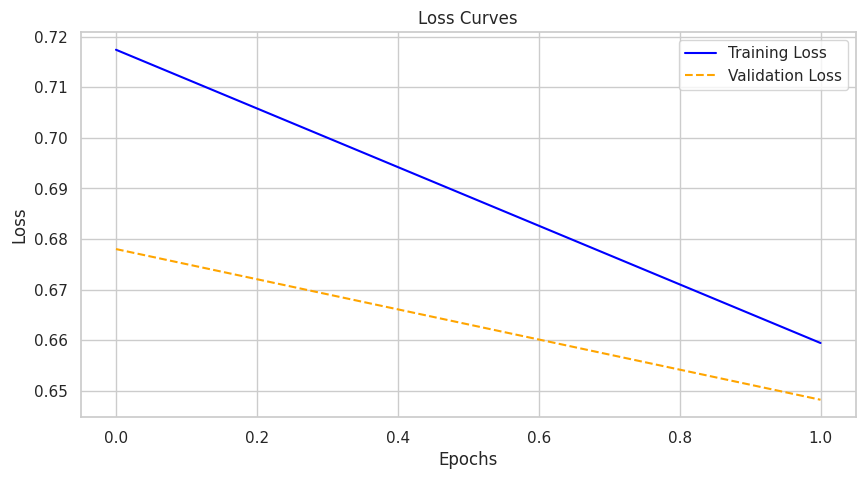

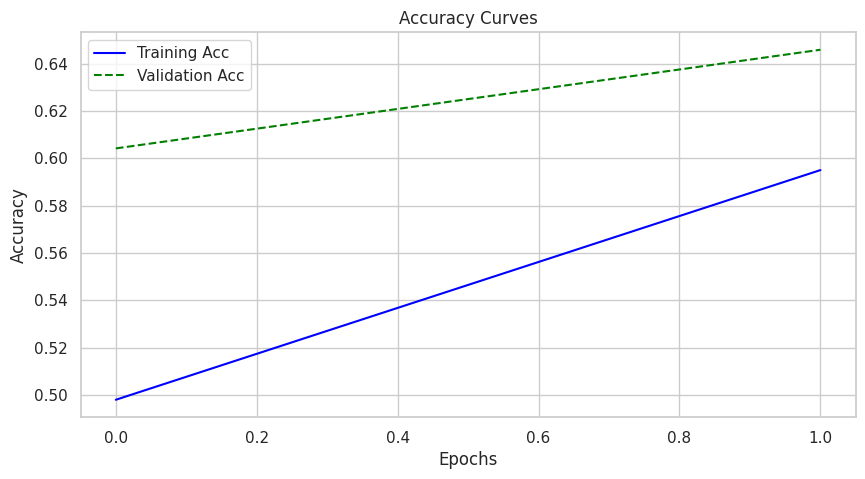

In [15]:

# =============================================================================
#  Plot Training Curves
# =============================================================================

os.makedirs(CONFIG["RESULTS_DIR"], exist_ok=True)

plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label="Training Loss", color="blue")
plt.plot(val_loss_history, label="Validation Loss", color="orange", linestyle="--")
plt.title("Loss Curves")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(CONFIG["RESULTS_DIR"], "loss_curves.png"), dpi=200)
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(train_acc_history, label="Training Acc", color="blue")
plt.plot(val_acc_history, label="Validation Acc", color="green", linestyle="--")
plt.title("Accuracy Curves")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(CONFIG["RESULTS_DIR"], "accuracy_curves.png"), dpi=200)
plt.show()


In [16]:
# =============================================================================
#  Analyze Fit Status
# =============================================================================

final_train_acc = train_acc_history[-1] if train_acc_history else 0
final_val_acc = val_acc_history[-1] if val_acc_history else 0
check_fit_status("HQNN", final_train_acc, final_val_acc)


===== FIT ANALYSIS → HQNN =====
Train Acc: 0.595
Val Acc:   0.646
Gap:       -0.051
 GOOD FIT: No signs of over/underfitting.


In [17]:
# =============================================================================
#  Save Model and Metadata
# =============================================================================

if best_model_state is not None:
    model.load_state_dict(best_model_state)

torch.save(model.state_dict(), os.path.join(CONFIG["RESULTS_DIR"], "best_model_qnn.pt"))

config_serializable = {k: str(v) if isinstance(v, Path) else v for k, v in CONFIG.items()}
meta = {
    "config": config_serializable,
    "top3_features": FEATURES,
    "best_val_loss": float(best_val_loss),
}
with open(os.path.join(CONFIG["RESULTS_DIR"], "run_meta.json"), "w") as f:
    json.dump(meta, f, indent=2)

print("Model and metadata saved.")

Model and metadata saved.


In [18]:
# =============================================================================
#  Test Evaluation
# =============================================================================

model.eval()
y_true = []
y_pred = []
y_probs = []

with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)
        output = model(data)
        probs = torch.softmax(output, dim=1)
        preds = torch.argmax(probs, dim=1)
        y_true.extend(targets.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_probs.extend(probs[:, 1].cpu().numpy())

print("\n" + "=" * 40)
print("FINAL TEST RESULTS")
print("=" * 40)
print(classification_report(y_true, y_pred))



FINAL TEST RESULTS
              precision    recall  f1-score   support

           0       0.62      0.44      0.51       130
           1       0.63      0.78      0.70       159

    accuracy                           0.63       289
   macro avg       0.62      0.61      0.61       289
weighted avg       0.62      0.63      0.61       289



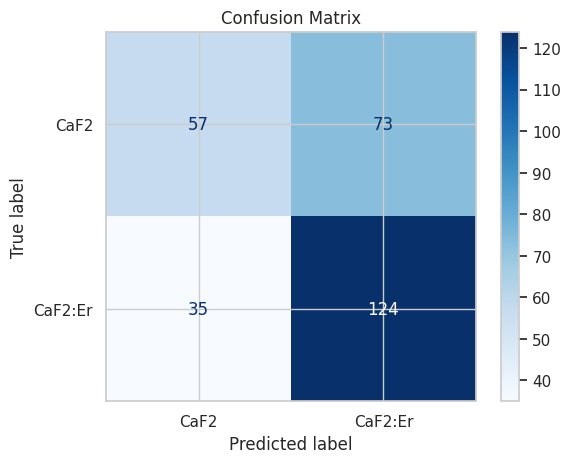

In [19]:
# =============================================================================
#  Confusion Matrix
# =============================================================================

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["CaF2", "CaF2:Er"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig(os.path.join(CONFIG["RESULTS_DIR"], "confusion_matrix.png"), dpi=200)
plt.show()


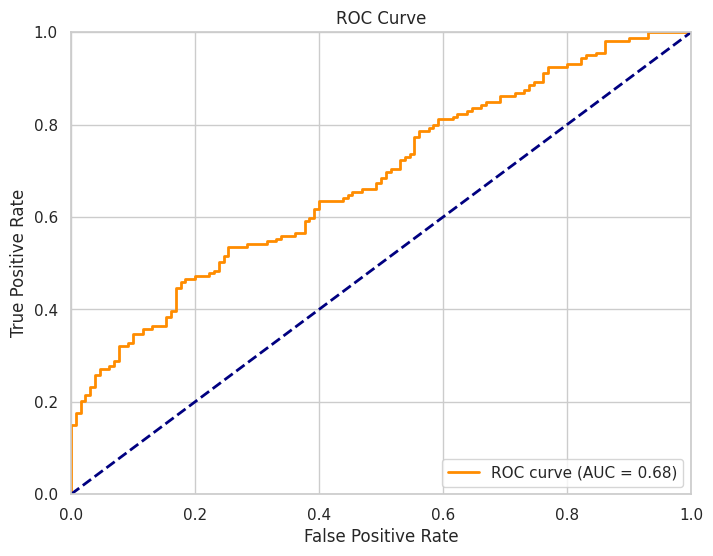

In [20]:
# =============================================================================
#  ROC Curve
# =============================================================================

fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig(os.path.join(CONFIG["RESULTS_DIR"], "roc_curve.png"), dpi=200)
plt.show()
